# Initialisation

In [1]:
#Importing all the necessary libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as TTS, KFold as K, cross_val_score as score  
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR 
from xgboost import XGBRegressor as XGR
import warnings
warnings.filterwarnings('ignore')

import pickle

#Importing the datset
df = pd.read_csv(r'../Data/flight_price.csv')
vase=df.head(3)

In [2]:
df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [4]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [5]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662


# Data preprocessing

In [6]:
###################################################################################################################
#
#def preprocess(df):
# Input: main dataframe
#
# 1. Correct the datatypes
# 2. Generate new features
# 3. Drop previous features which are irrelevant now 
# 4. return X, y
###################################################################################################################

def preprocess(df):

    #1. Correcting the datatypes    
    date_conv = lambda x: dt.strptime(str(x), '%d/%m/%Y')
    time_conv = lambda x: dt.strptime(str(x), '%H:%M')
    df['Date_of_Journey'] = df['Date_of_Journey'].apply(date_conv)

    #2. Generate new features
    hour = lambda x: x[x.index(":")-2:x.index(":")]
    minutes = lambda x: x[x.index(":")+1:x.index(":")+3]
    dur_hour = lambda x:x[:x.index("h")] if 'h' in x else 0
    dur_min = lambda x: x[x.index("m")-2:x.index("m")] if 'm' in x else 0
    stops = lambda x: 1 if '1' in str(x) else (2  if '2' in str(x) else(3 if '3' in str(x) else(4 if '4' in str(x) else (5 if '5' in str(x)else 0))))
    tod = lambda x: 'early morning' if 0<x<=6 else('morning' if 6<x<=12 else ('noon' if 12<x<=16 else ('evening' if 16<x<=20 else 'night')))

    df['Dep_hour'] = df.Dep_Time.apply(hour)
    df['Dep_minutes'] = df.Dep_Time.apply(minutes)
    df['Duration_hours'] = df.Duration.apply(dur_hour)
    df['Duration_mins'] = df.Duration.apply(dur_min)
    df.Duration_mins.replace({'':'0'},inplace=True)
    df['N_stops'] = df.Total_Stops.apply(stops)
    df.Dep_hour = df.Dep_hour.astype(int)
    df.Dep_minutes = df.Dep_minutes.astype(int)
    df.Duration_hours = df.Duration_hours.astype(int)
    df.Duration_mins = df.Duration_mins.astype(int)
    df.N_stops = df.N_stops.astype(int)
    df=df[df.N_stops==0]
   
    df[['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'SpiceJet','Vistara', 'Vistara Premium economy']]=pd.get_dummies(df.Airline)
    
    df[['In-flight meal not included', 'No check-in baggage included',
       'No info', 'Red-eye flight']]=pd.get_dummies(df.Additional_Info)

    df.Additional_Info.replace({'No Info':'No info'}, inplace=True)
    
    df['Day of month'] = df.Date_of_Journey.apply(lambda x: x.strftime("%d")).astype(int)
    df['Day of week'] = df.Date_of_Journey.apply(lambda x: x.strftime("%w")).astype(int)
    df['Month of year'] = df.Date_of_Journey.apply(lambda x: x.strftime("%m")).astype(int)
    df['Day of year'] = df.Date_of_Journey.apply(lambda x: x.timetuple().tm_yday)
    df['TOD of departure'] = df.Dep_hour.apply(tod)

    df[['Dep_early morning', 'Dep_evening', 'Dep_morning', 'Dep_night', 'Dep_noon']] = pd.get_dummies(df['TOD of departure'])
   #3. Dropping previous and now irrelevant features

    df.drop(['Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops','Additional_Info','Airline', 'Date_of_Journey','Route','TOD of departure', 'No check-in baggage included','Jet Airways', 'Vistara Premium economy','Vistara Premium economy','Red-eye flight','N_stops','No info','In-flight meal not included'],axis=1, inplace=True)
   
    df.Destination.replace({'Delhi':'New Delhi'},inplace=True)
    df.Source.replace({'Delhi':'New Delhi'},inplace=True)
    df.Destination.replace({'Banglore':'Bangalore'},inplace=True)
    df.Source.replace({'Banglore':'Bangalore'},inplace=True)

    thresh = np.quantile(df.Price,0.75) + 1.5*(np.quantile(df.Price,0.75)-np.quantile(df.Price,0.25))
    df = df[df.Price<thresh]
    df['Src-Dest'] = df.Source+"-"+df.Destination

    dic={'Bangalore-New Delhi':1, 'Chennai-Kolkata':2, 'New Delhi-Cochin':3,
       'Kolkata-Bangalore':4, 'Mumbai-Hyderabad':5}

    df['route'] = df['Src-Dest'].apply(lambda x : dic[x])     
    df.drop(['Src-Dest','Source','Destination'],axis=1,inplace=True)
    df=df[((df['IndiGo']==0) & (df['Air India']==0) & (df['Air Asia']==0) & (df['SpiceJet']==0) & (df['Vistara']==0) & (df['GoAir']==0))==0]
    X = df.drop(['Price'],axis=1)
    y = df['Price'] 
    return X,y 

In [7]:
X,y=preprocess(df)

<AxesSubplot:xlabel='Price'>

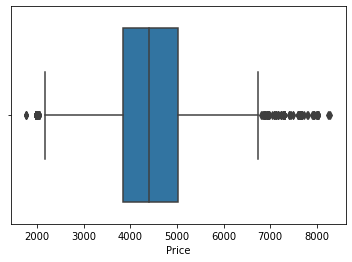

In [8]:
sns.boxplot(y)

# Model

In [9]:
def models(model):

    folds=K(n_splits=5, shuffle=True, random_state=4)
    r=score(model,X,y,scoring='neg_mean_absolute_error',cv=folds)
    scores = str(-round(r.mean(),2))+" ± "+str(round(r.std(),2))
    return scores

In [10]:
d=DTR(max_depth=14)
r=RFR(max_depth=16, random_state=123456)
x=XGR(max_depth=5,eta=0.5, subsample=0.92)
print("Absolute error for Decision tree regressor",models(d))    #Median best max_depth after 100 iterations of cross validation
print("Absolute error for Random forest regressor",models(r))
print("Absolute error for XGB Regressor",models(x))

Absolute error for Decision tree regressor 301.32 ± 18.86
Absolute error for Random forest regressor 261.89 ± 13.87
Absolute error for XGB Regressor 308.28 ± 15.16


In [11]:
r.fit(X,y)

RandomForestRegressor(max_depth=16, random_state=123456)

In [12]:
rr=DTR(max_depth=16)
rr.fit(X,y)
pd.DataFrame(rr.feature_importances_*100,index=X.columns).sort_values(0,ascending=False).style.background_gradient(cmap='Reds')


,0
route,33.041219
Day of year,25.415834
Air India,8.791365
Dep_hour,7.210286
SpiceJet,5.945429
Duration_mins,4.395564
Dep_minutes,3.202283
Day of month,2.238180
Duration_hours,2.148296
Day of week,1.904648


# Deployment

In [13]:
df.Destination.replace({'Delhi':'New Delhi'},inplace=True)
df.Source.replace({'Delhi':'New Delhi'},inplace=True)
df.Destination.replace({'Banglore':'Bangalore'},inplace=True)
df.Source.replace({'Banglore':'Bangalore'},inplace=True)
hours_calc=df[['Airline','Source','Destination','Duration_hours','Duration_mins']]
hours_calc=hours_calc[hours_calc.Airline.isin(['IndiGo','SpiceJet','Air Asia','GoAir','Vistara'])]
hours_calc=hours_calc.groupby(['Airline','Source','Destination'])[['Duration_hours','Duration_mins']].mean().reset_index()

In [14]:
hours_calc.to_csv(r"../deployment/hour_calculation.csv", index=False)

In [15]:
with open('..\deployment\model','wb') as f:
    pickle.dump(r,f)